# Continuous Entropy

https://gtas.unican.es/files/docencia/TICC/apuntes/tema1bwp_0.pdf \\
https://statproofbook.github.io/P/mvn-dent.html
- Gaussion distribution: 
$f(x)=\dfrac{1}{\sqrt{2\pi}\ ⋅ \sigma} e^{-\dfrac{1}{2 \sigma^2}(x-\mu)^2}$ 

- Joint Gaussion distribution:
$f_{X, Y}(x, y)=\dfrac{1}{2 \pi \sigma_X \sigma_Y \sqrt{1-\rho^2}} \exp \left[-\dfrac{1}{2\left(1-\rho^2\right)} S\right] \\S=\left(\dfrac{x-\mu_X}{\sigma_X}\right)^2+\left(\dfrac{y-\mu_Y}{\sigma_Y}\right)^2-2 \rho \dfrac{\left(x-\mu_X\right)\left(y-\mu_Y\right)}{\sigma_X \sigma_Y}\\ \rho=\rho(X, Y)=\dfrac{\operatorname{Cov}(X, Y)}{\sigma_X \sigma_Y} = \dfrac{\sum\limits_{i=1}^n\left(x_i-\mu_x\right)\left(y_i-\mu_y\right)}{\sqrt{\sum\limits_{i=1}^n\left(x_i-\mu_x\right)^2 \sum\limits_{i=1}^n\left(y_i-\mu_y\right)^2}}$

- Continuous Entropy:
$H(X)=\int_S f(x) \log \dfrac{1}{f(x)} d x ⇒ \dfrac{1}{2} \log \left(2 \pi e \sigma^2\right)$
- KL divergence(Relative Entropy):
$KL(P \| Q)=\int_S p(x) \log {\left(\dfrac{p(x)}{q(x)}\right)} d x ⇒ \dfrac{1}{2} \log e\left(\ln \left(\dfrac{\sigma_2^2}{\sigma_1^2}\right)+\dfrac{\sigma_1^2}{\sigma_2^2}+\dfrac{\left(\mu_1-\mu_2\right)^2}{\sigma_2^2}-1\right) ⇒ \dfrac{1}{2} \left(\ln \left(\dfrac{\sigma_2^2}{\sigma_1^2}\right)+\dfrac{\sigma_1^2}{\sigma_2^2}+\dfrac{\left(\mu_1-\mu_2\right)^2}{\sigma_2^2}-1\right)$
- Continuous JS-Entropy:
$JS(f(x)||g(x))={1 \over 2}(KL(f(x)||g(x))+KL(g(x)||f(x)))$
- Continuous Joint Entropy for Multivariate Gaussion
$H(X, Y)=-\int_{S_x} \int_{S_y} p(x, y) \log p(x, y) d x d y =\dfrac{n}{2} \ln (2 \pi)+\dfrac{1}{2} \ln |\Sigma|+\dfrac{1}{2} n $
- Continuous MI with matrix: $I(X ; Y)=\int_{S_x} \int_{S_y} p(x, y) \log \dfrac{p(x, y)}{p(x) p(y)} d x d y$ $= H(x)+H(y)-H(x,y) $

In [70]:
import pandas as pd
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import dblquad
from dataclasses import dataclass
from scipy.linalg import det
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# TODO: multi-collinearity, missing rate, classification entropy, return modules

@dataclass
class continuous:
    dependent_var: str = None

    def _gaussion(self, x, data_list):
        mean = np.mean(data_list)
        std = np.std(data_list) 
        return 1/(np.sqrt(2*np.pi)*std)*np.exp(-1/2*((x-mean)/std)**2)

    def _pearson_corr_coefficient(self, data_list_1, data_list_2):
        mu_x = np.mean(data_list_1)
        mu_y = np.mean(data_list_2) 
        std_x = np.std(data_list_1)
        std_y = np.std(data_list_2)
        # cov_x_y = sum((a - mu_x) * (b - mu_y) for (a,b) in zip(data_list_1,data_list_2)) / len(data_list_1)
        return sum((a - mu_x) * (b - mu_y) for (a,b) in zip(data_list_1,data_list_2)) / len(data_list_1)/(std_x*std_y), mu_x, mu_y, std_x, std_y

    
    def _joint_gaussion(self, x, y, data_list_1, data_list_2):
        rho, mu_x, mu_y, std_x, std_y  = self._pearson_corr_coefficient(data_list_1, data_list_2)
        x_diff = x-mu_x
        y_diff = y-mu_y
        S = (x_diff/std_x)**2 + (y_diff/std_y)**2 - 2*rho*x_diff*y_diff/(std_x* std_y)
        return 1/(2*np.pi*std_x*std_y*np.sqrt(1 - rho**2))*np.exp(-S/(2*(1-rho**2)))
        
    def entropy(self, data_list):
        # result, _ = integrate.quad(lambda x: self._gaussion(x, data_list)*np.log(1/self._gaussion(x, data_list)), -30,30)
        return 1/2*np.log(2*np.pi*np.e*np.std(data_list)**2)

    def relative_entropy(self, data_list_1, data_list_2):
        std_1 = np.std(data_list_1)
        std_2 = np.std(data_list_2)
        # result, _ = integrate.quad(lambda x: self._gaussion(x, data_list_1)* np.log(self._gaussion(x, data_list_1)/self._gaussion(x, data_list_2)), -30,30)
        return 1/2*(np.log(std_2**2/std_1**2) + std_1**2/std_2**2 + (np.mean(data_list_1)-np.mean(data_list_2))**2/std_2**2 -1)

    def js_divergence(self, data_list_1, data_list_2):
        M = [(x + y) / 2 for x, y in zip(data_list_1, data_list_2)]
        return 1/2*(self.relative_entropy(data_list_1, M)+ self.relative_entropy(data_list_2, M)), self.relative_entropy(data_list_1, data_list_2), self.relative_entropy(data_list_2, data_list_1)

    def joint_entropy_2(self, data_list_1, data_list_2):
        ''' 
        entropy under both consideration
        '''

        if list(data_list_1) == list(data_list_2):
            return self.entropy(data_list_1)
        f = lambda x, y: -self._joint_gaussion(x, y, data_list_1, data_list_2)*np.log(self._joint_gaussion(x, y, data_list_1, data_list_2))
        val, _ = integrate.dblquad(f, -20, 20, -20, 20)
        return val
        # n = 2
        # cov_matrix = np.cov(data_list_1, data_list_2)
        # return (1/2)*(n*np.log(2*np.pi) + n + np.log(det(cov_matrix)))

    def multi_collinearity(self, df):
        df_corr = df.corr()  
        display(df_corr.style.background_gradient(cmap='coolwarm'))
        
    def missing_rate(self, df):
        missing = df.isnull().sum()
        missing_rate = missing / len(df)
        total_missing_rate = missing.sum() / (len(df) * len(df.columns))
        
        result = pd.DataFrame({'missing_rate': missing_rate})
        display(result)
        print(total_missing_rate)

    def basic_info(self, col_list):
        # mean, var, corr_matrix, Q1-Q3 of each column
        min = np.mean(col_list)
        max = np.max(col_list)
        avg = np.mean(col_list)
        q1 = np.percentile(col_list, 25)
        q3 = np.percentile(col_list, 75)
        std = np.std(col_list)   
        skewness = stats.skew(col_list)
        kurtosis = stats.kurtosis(col_list)
        return min, max, avg, q1, q3, std, skewness, kurtosis


    def compare_base(self, df, method = "zero"):
        "when need to compare with missing data, consider drop all missing value or take the case as 0"
        if method == 'drop':
            return df.copy().dropna()
        elif method == "zero":  
            return df.copy().fillna(0,inplace=True)

    def pair_plot(self, df_before, df_after):
        da, db = df_after.copy(), df_before.copy()
        da['imputed'] = True
        db['imputed'] = False
        combined_df = pd.concat([db, da], ignore_index=True)
        sns.set(style='ticks')
        plot = sns.pairplot(combined_df, kind='reg', hue='**impute**', diag_kind='hist', diag_kws={'alpha': 0.5}, plot_kws={'scatter_kws': {'alpha': 0.3}})
        plt.show()

    def simplification(self, df_before, df_after):
        pass
    def comparison(self, df_before, df_after, method='all'):
        """
        Compare some metrics to show difference percentage of imputed before/after
        """
        # entropy_pair_list = []
        # js_divergence_list = []
        df_entropy = {}
        js_divergence = {}
        df_basic_before = {}
        df_basic_after = {}

        # for entropy
        for col in df_before.columns:
            entropy_before, entropy_after = self.entropy(df_before[col]), self.entropy(df_after[col])
            min_before, max_before, avg_before, q1_before, q3_before, std_before, skewness_before, kurtosis_before = self.basic_info(df_before[col])
            min_after, max_after, avg_after, q1_after, q3_after, std_after, skewness_after, kurtosis_after = self.basic_info(df_after[col])
            df_entropy.update({col:[entropy_before, entropy_after, abs(entropy_before-entropy_after), self.percentage_difference(entropy_before, entropy_after)]})
            js, kl_12, kl_21 = self.js_divergence(df_before[col], df_after[col])
            js_divergence.update({col: [js, kl_12, kl_21]})
            df_basic_before.update({col:[min_before, max_before, avg_before, q1_before, q3_before, std_before, skewness_before, kurtosis_before]})
            df_basic_after.update({col:[min_after, max_after, avg_after, q1_after, q3_after, std_after, skewness_after, kurtosis_after]})

        df_entropy = pd.DataFrame(df_entropy, index=['entropy_before', 'entropy_after', 'difference', 'percentage_difference'])
        df_entropy.columns.name = 'Entropy'

        js_divergence = pd.DataFrame(js_divergence, index=['js_divergence', 'KL(1||2)', 'KL(2||1)'])
        js_divergence.columns.name = 'KL-Divergence'

        df_basic_before = pd.DataFrame(df_basic_before, index=['min', 'max', 'avg', 'q1', 'q3', 'std', 'skewness', 'kurtosis'])
        df_basic_after = pd.DataFrame(df_basic_after, index=['min', 'max', 'avg', 'q1', 'q3', 'std', 'skewness', 'kurtosis'])
        df_basic_before.columns.name = 'Basic Info Before'
        df_basic_after.columns.name = 'Basic Info After'
        
        print('\n*** Missing Rate ***')
        missing_rate(df_before)

        print('\n*** Entropy ***')
        display(df_entropy.applymap(lambda x: format(x, '.2e')))

        print('\n*** KL Divergence(Relative Entropy) ***')
        display(js_divergence.applymap(lambda x: format(x, '.2e')))

        print('\n*** Basic Info ***')
        display(df_basic_before.applymap(lambda x: format(x, '.2e')))
        display(df_basic_after.applymap(lambda x: format(x, '.2e')))

        print('\n*** Covarience ***')
        # 繪製heatmap
        plt.figure(figsize=(8, 8))
        cov_mat = df_before.cov()
        ax = sns.heatmap(cov_mat, annot=True, cmap='coolwarm')
        plt.title('Covariance Matrix Before')
        plt.show()

        plt.figure(figsize=(8, 8))
        cov_mat_2 = df_after.cov()
        ax = sns.heatmap(cov_mat_2, annot=True, cmap='coolwarm')
        plt.title('Covariance Matrix After')
        plt.show()
        
        print('\n*** Multi-Collinearity ***')
        print('\n--- Before ---')
        self.multi_collinearity(df_before)
        print('\n--- After ---')
        self.multi_collinearity(df_after)
        

        print('\n*** Pairplot ***')
        self.pair_plot(df_before, df_after)

    def percentage_difference(self, a, b):
        return (b-a)/a
    

# Test

In [67]:
import numpy as np
from scipy.stats import entropy
# base = 2  # work in units of bits
# pk = np.array([1,2,1,1])  # fair coin
# H = entropy(pk)
# print(H)



def differential_entropy(data_list):
    # result, _ = integrate.quad(lambda x: self._gaussion(x, data_list)*np.log(1/self._gaussion(x, data_list)), -30,30)
    return 1/2*np.log(2*np.pi*np.e*np.std(data_list)**2)

entropy([1,1,1,1],2)

def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

def js_divergence(p, q):
    return 0.5*kl_divergence(p,q) + 0,5*kl_divergence(q,p)


kl_divergence([1,1,1],[1,1,1])
# np.std([1,1,1])

43.01955000865387


*** Missing Rate ***
0.0

*** Entropy ***


Entropy,var1,var2,var3,var4,var5,var6,var7
entropy_before,1.39e+00,1.42e+00,1.38e+00,1.39e+00,1.38e+00,1.40e+00,1.43e+00
entropy_after,1.46e+00,1.43e+00,1.44e+00,1.33e+00,1.51e+00,1.41e+00,1.33e+00
difference,7.09e-02,9.50e-03,5.64e-02,6.43e-02,1.33e-01,5.44e-03,9.98e-02
percentage_difference,5.11e-02,6.67e-03,4.08e-02,-4.62e-02,9.68e-02,3.87e-03,-6.97e-02



*** KL Divergence(Relative Entropy) ***


KL-Divergence,var1,var2,var3,var4,var5,var6,var7
js_divergence,9.17e-02,1.68e-01,1.82e-01,1.98e-01,1.94e-01,7.66e-02,1.86e-01
KL(1||2),5.00e-03,2.33e-03,6.43e-03,8.77e-03,2.68e-02,1.31e-03,1.48e-02
KL(2||1),5.51e-03,2.37e-03,7.07e-03,7.88e-03,3.32e-02,1.33e-03,1.27e-02



*** Basic Info ***


Basic Info Before,var1,var2,var3,var4,var5,var6,var7
min,1.46e-02,-1.51e-02,3.30e-02,3.60e-02,2.65e-02,1.99e-02,-1.86e-02
max,3.31e+00,3.53e+00,3.67e+00,3.44e+00,3.01e+00,2.92e+00,3.00e+00
avg,1.46e-02,-1.51e-02,3.30e-02,3.60e-02,2.65e-02,1.99e-02,-1.86e-02
q1,-6.61e-01,-6.94e-01,-6.13e-01,-6.61e-01,-6.41e-01,-6.65e-01,-7.34e-01
q3,6.45e-01,6.91e-01,6.73e-01,7.18e-01,6.96e-01,6.56e-01,6.65e-01
std,9.70e-01,1.01e+00,9.63e-01,9.71e-01,9.59e-01,9.86e-01,1.01e+00
skewness,4.85e-02,-5.18e-02,1.93e-01,5.44e-03,-2.03e-02,1.28e-02,-3.68e-02
kurtosis,3.98e-02,2.60e-01,1.78e-01,-7.44e-02,-1.76e-01,5.08e-02,-2.01e-01


Basic Info After,var1,var2,var3,var4,var5,var6,var7
min,-6.22e-03,5.28e-02,-5.07e-02,-5.00e-02,-1.33e-01,-3.04e-02,6.48e-02
max,2.74e+00,2.34e+00,2.50e+00,1.78e+00,2.50e+00,2.43e+00,3.05e+00
avg,-6.22e-03,5.28e-02,-5.07e-02,-5.00e-02,-1.33e-01,-3.04e-02,6.48e-02
q1,-5.33e-01,-7.09e-01,-8.19e-01,-6.24e-01,-1.00e+00,-6.90e-01,-5.62e-01
q3,6.10e-01,6.22e-01,6.33e-01,6.01e-01,6.25e-01,6.80e-01,6.47e-01
std,1.04e+00,1.02e+00,1.02e+00,9.11e-01,1.10e+00,9.91e-01,9.17e-01
skewness,-4.99e-01,3.50e-02,1.31e-01,-4.05e-01,2.77e-01,-1.31e-01,5.19e-01
kurtosis,9.35e-01,-1.77e-01,-5.44e-01,-2.35e-01,-5.43e-01,-1.34e-01,1.38e-01



*** Covarience ***


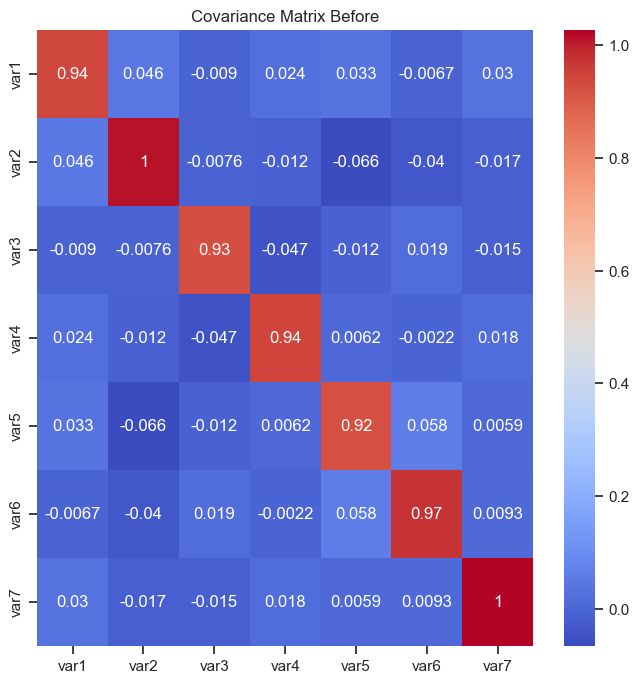

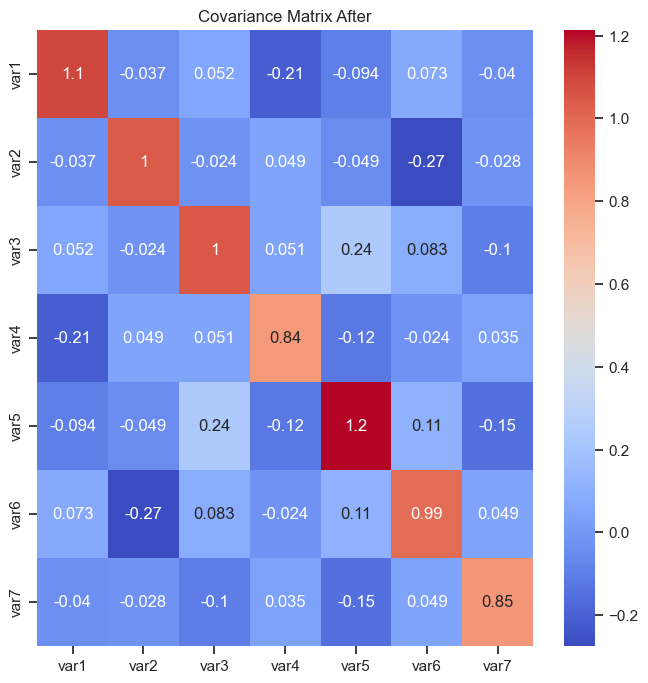


*** Multi-Collinearity ***

--- Before ---


,var1,var2,var3,var4,var5,var6,var7
var1,1.000000,0.046903,-0.009603,0.025199,0.035651,-0.007039,0.030768
var2,0.046903,1.000000,-0.007805,-0.012009,-0.068199,-0.040394,-0.016618
var3,-0.009603,-0.007805,1.000000,-0.050305,-0.013362,0.019531,-0.015393
var4,0.025199,-0.012009,-0.050305,1.000000,0.006664,-0.002328,0.018428
var5,0.035651,-0.068199,-0.013362,0.006664,1.000000,0.061572,0.006022
var6,-0.007039,-0.040394,0.019531,-0.002328,0.061572,1.000000,0.009307
var7,0.030768,-0.016618,-0.015393,0.018428,0.006022,0.009307,1.000000



--- After ---


,var1,var2,var3,var4,var5,var6,var7
var1,1.000000,-0.034720,0.048641,-0.223011,-0.081426,0.070311,-0.041829
var2,-0.034720,1.000000,-0.022578,0.052888,-0.043313,-0.269316,-0.029988
var3,0.048641,-0.022578,1.000000,0.054331,0.214462,0.081037,-0.109319
var4,-0.223011,0.052888,0.054331,1.000000,-0.120651,-0.026690,0.041431
var5,-0.081426,-0.043313,0.214462,-0.120651,1.000000,0.100650,-0.148533
var6,0.070311,-0.269316,0.081037,-0.026690,0.100650,1.000000,0.053199
var7,-0.041829,-0.029988,-0.109319,0.041431,-0.148533,0.053199,1.000000



*** Pairplot ***


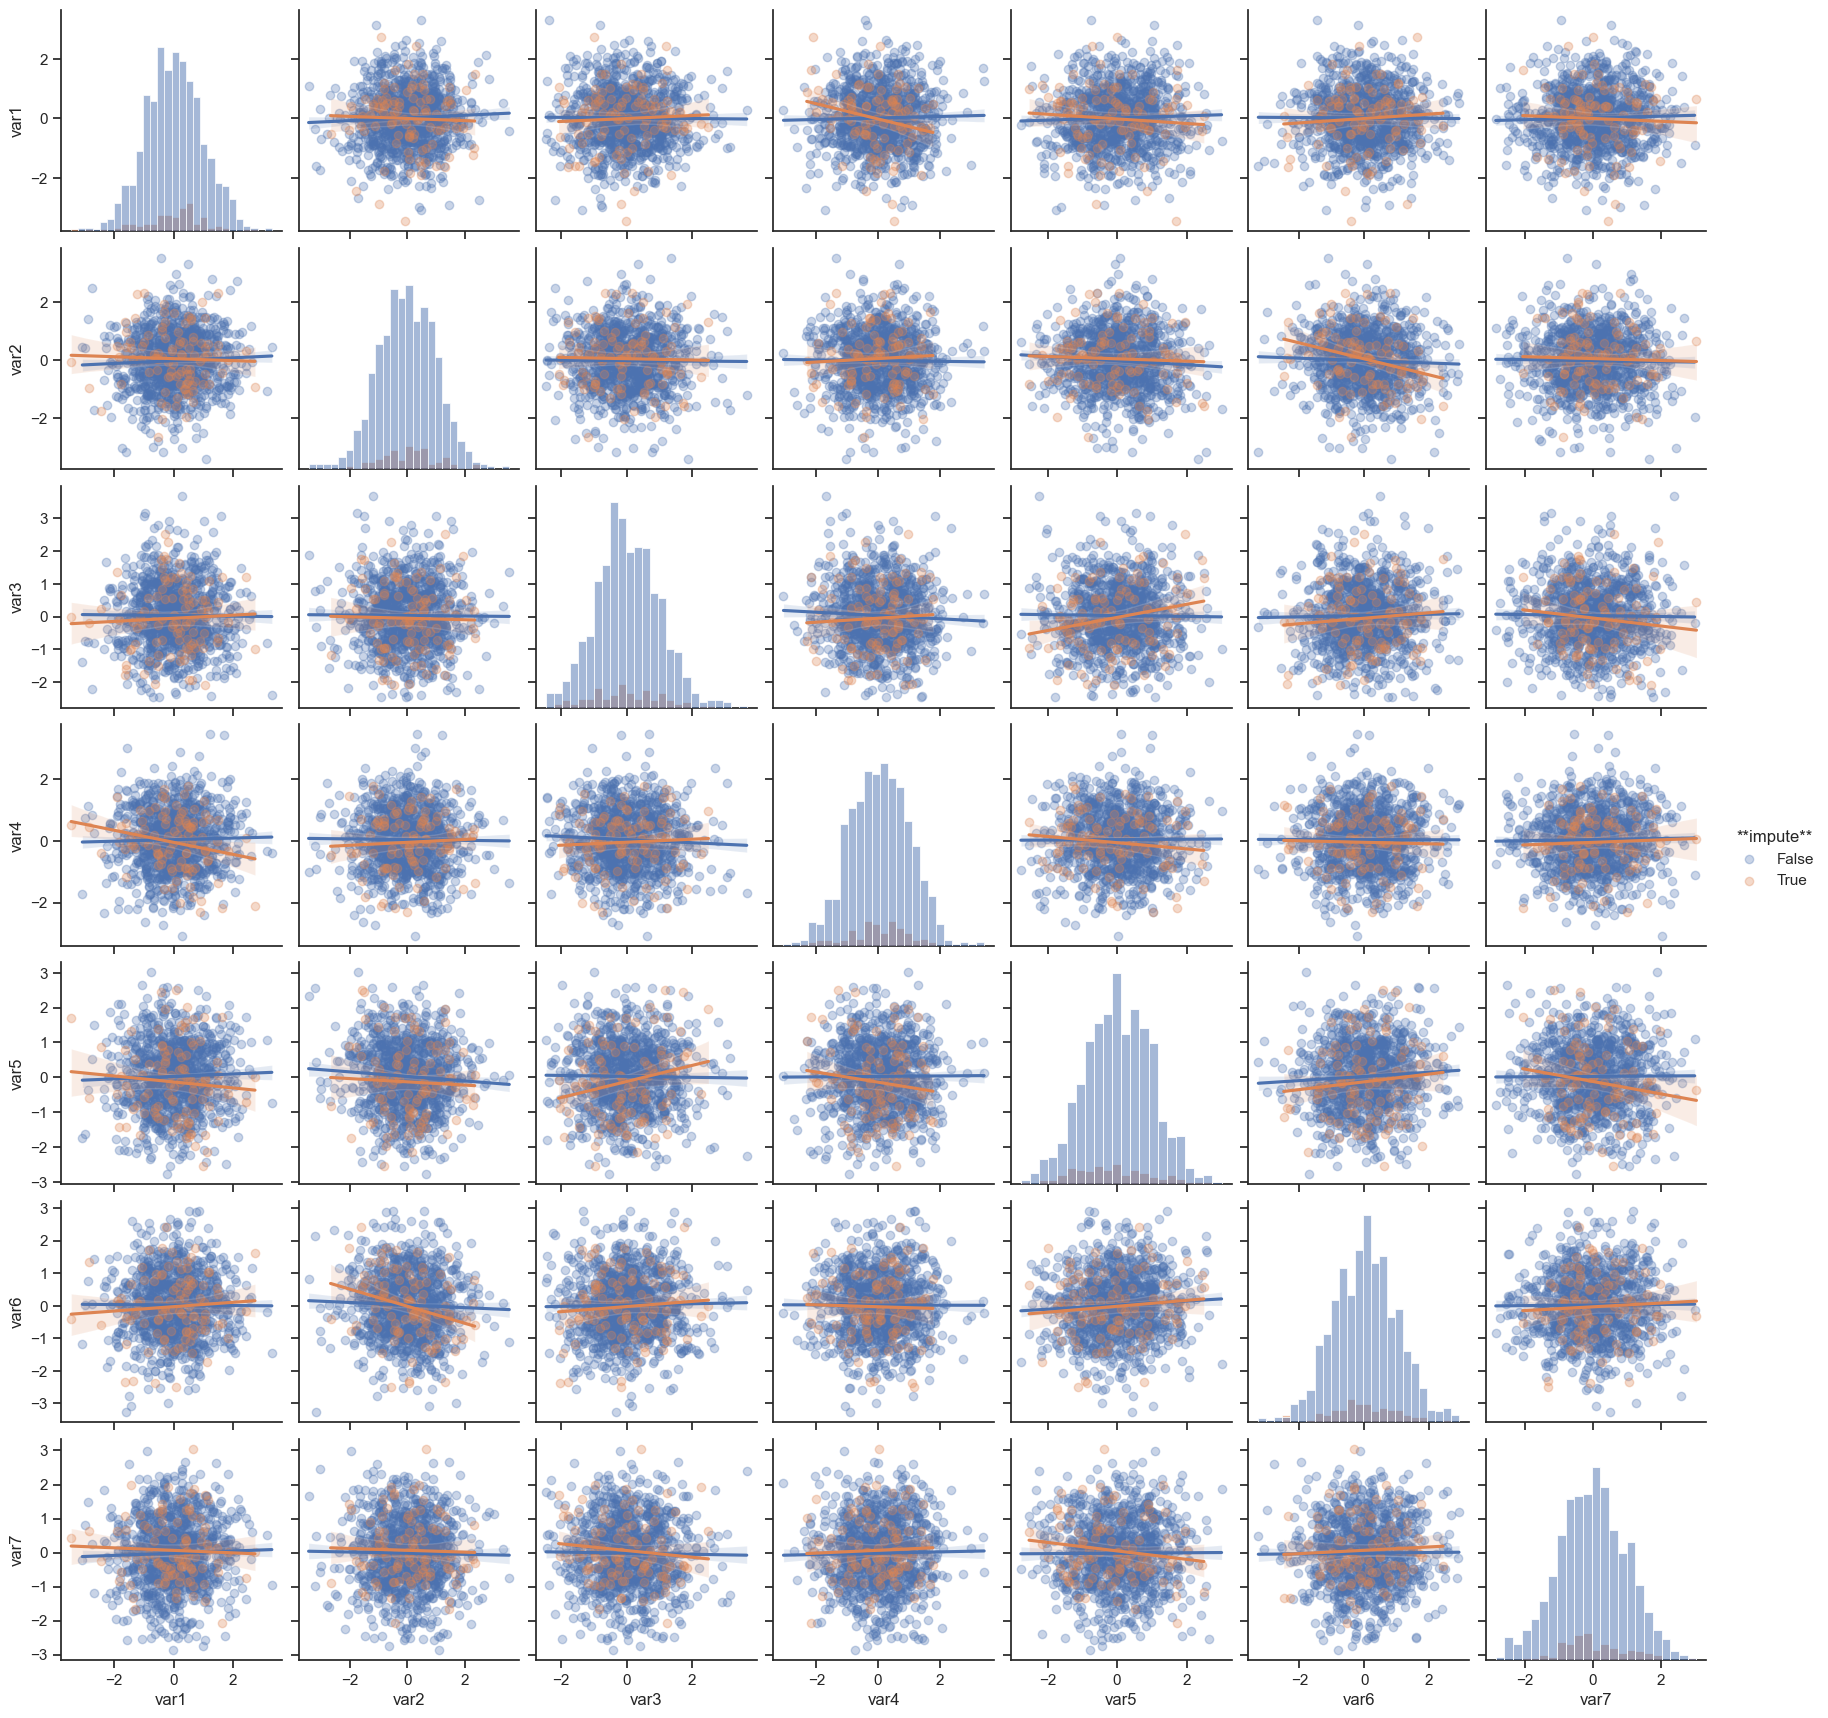

In [71]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(1000, 7), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'])
tmp = pd.DataFrame(np.random.randn(100, 7), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'])

con = continuous()
my_frame = con.comparison(df, tmp)

In [98]:
import pandas as pd
import numpy as np

# df = pd.DataFrame(np.random.randn(1000, 7), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'])
# tmp = pd.DataFrame(np.random.randn(100, 7), columns=['varw1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'])

# def multi_collinearity(df):
#     df_corr=df.corr()  
#     display(df_corr.style.background_gradient(cmap='coolwarm'))


# display(tmp)
# multi_collinearity(tmp)



data = {'A': [1, 2, np.nan, 4],
        'B': [np.nan, 6, 7, np.nan],
        'C': [9, np.nan, 11, 12],
        'D': [13, 14, 15, np.nan]}

df = pd.DataFrame(data)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["features"] = df.columns 
df_filled = df.fillna(0)
vif['VIF'] = [variance_inflation_factor(df_filled.values, i) for i in range(df_filled.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
display(vif)
# con = continuous()
# my_frame = con.comparison(df, tmp)

,features,VIF
3,D,4.765214
1,B,3.619609
2,C,2.678529
0,A,1.831929
